# 1. Installing Detectron

In [1]:
# Install PyTorch with CUDA support
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xwigt60b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xwigt60b
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 861.0 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2: Importing Libraries

In [2]:
import cv2

In [3]:
import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator

# Check if GPU is available
assert torch.cuda.is_available(), "CUDA is not available. Please enable a GPU Runtime in Kaggle."


# 3: Registering the Dataset

In [4]:
# Define dataset paths
dataset_path = '/kaggle/input/yolov10-cube-failure-coco-dataset/'
train_json = os.path.join(dataset_path, 'train/_annotations.coco.json')
val_json = os.path.join(dataset_path, 'valid/_annotations.coco.json')
train_images = os.path.join(dataset_path, 'train')
val_images = os.path.join(dataset_path, 'valid')

# Register the dataset in COCO format with the correct annotation file
register_coco_instances("cube_train", {}, train_json, train_images)
register_coco_instances("cube_val", {}, val_json, val_images)

# Metadata for visualization
cube_metadata = MetadataCatalog.get("cube_train")


# 4:  Model Configuration 

In [5]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cube_train",)
cfg.DATASETS.TEST = ("cube_val",)  # Validation during training
cfg.DATALOADER.NUM_WORKERS = 2

# Number of classes (just one: "cube")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Adjust learning rate
cfg.SOLVER.MAX_ITER = 1000  # Adjust the number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Adjust threshold

# Output directory for the model
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


# 5: Model Training

In [6]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

model_final_280758.pkl: 167MB [00:00, 205MB/s]                             
/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# 6 Evaluation

In [7]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("cube_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "cube_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

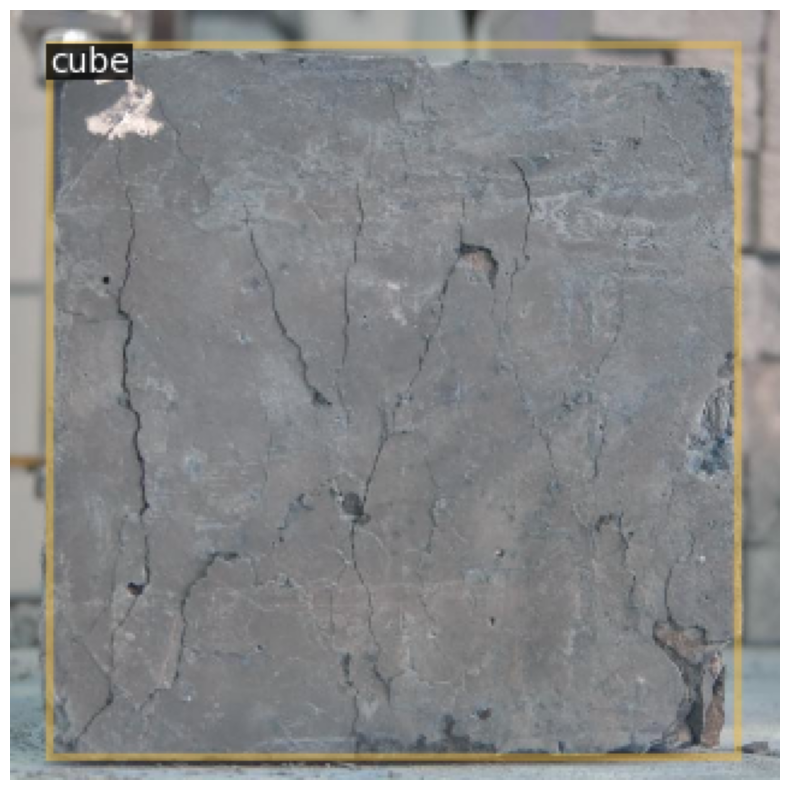

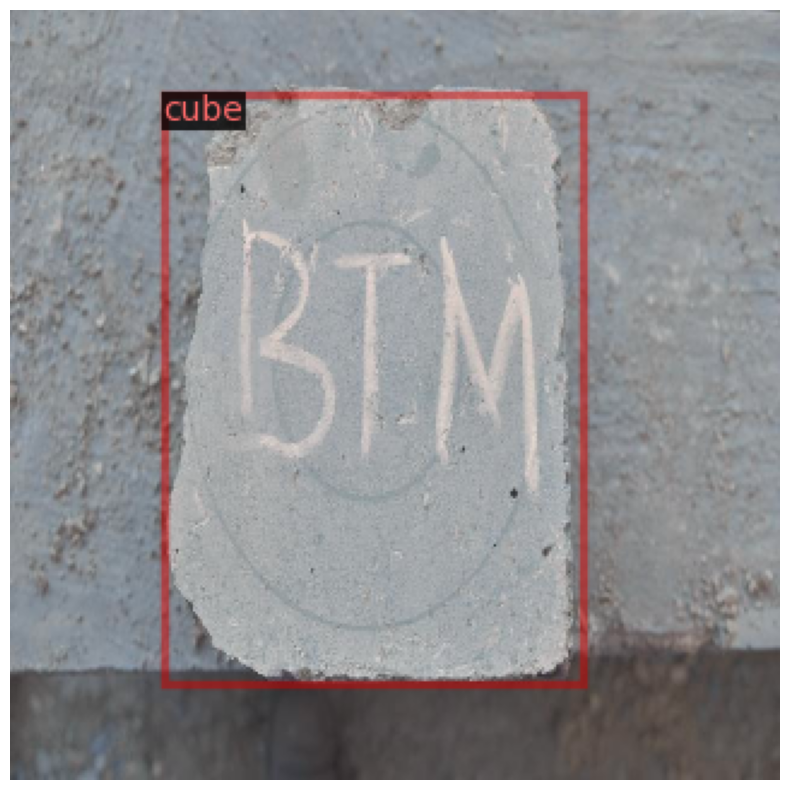

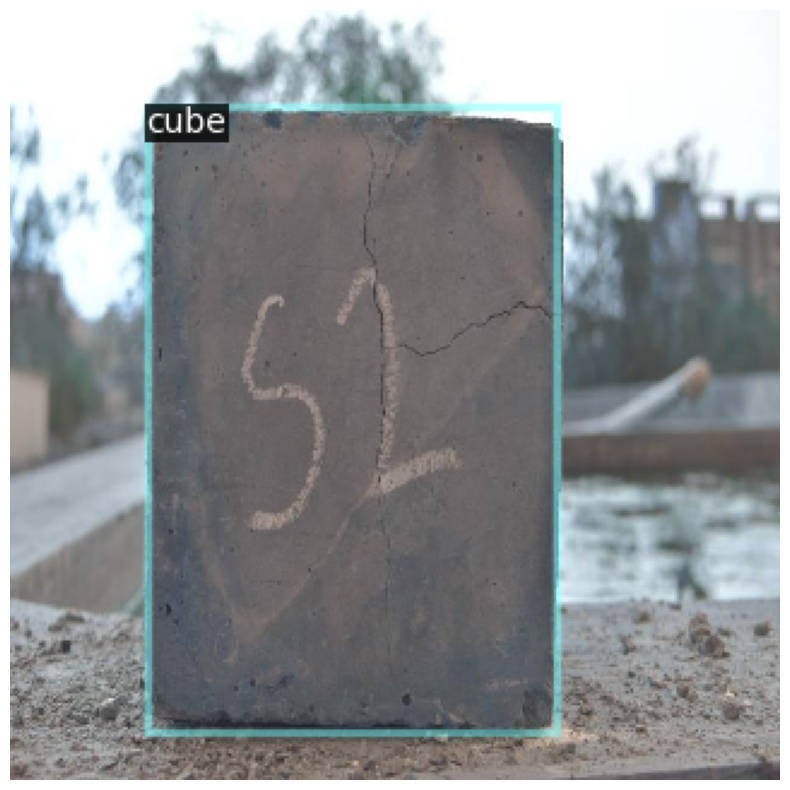

In [8]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode

# Load the validation dataset
dataset_dicts = DatasetCatalog.get("cube_val")

# Loop through 3 random samples
for d in random.sample(dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    
    # Visualize using Detectron2's Visualizer
    visualizer = Visualizer(img[:, :, ::-1], metadata=cube_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    
    # Convert image to RGB (from BGR) for matplotlib
    vis_img_rgb = vis.get_image()[:, :, ::-1]
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img_rgb)
    plt.axis('off')
    plt.show()



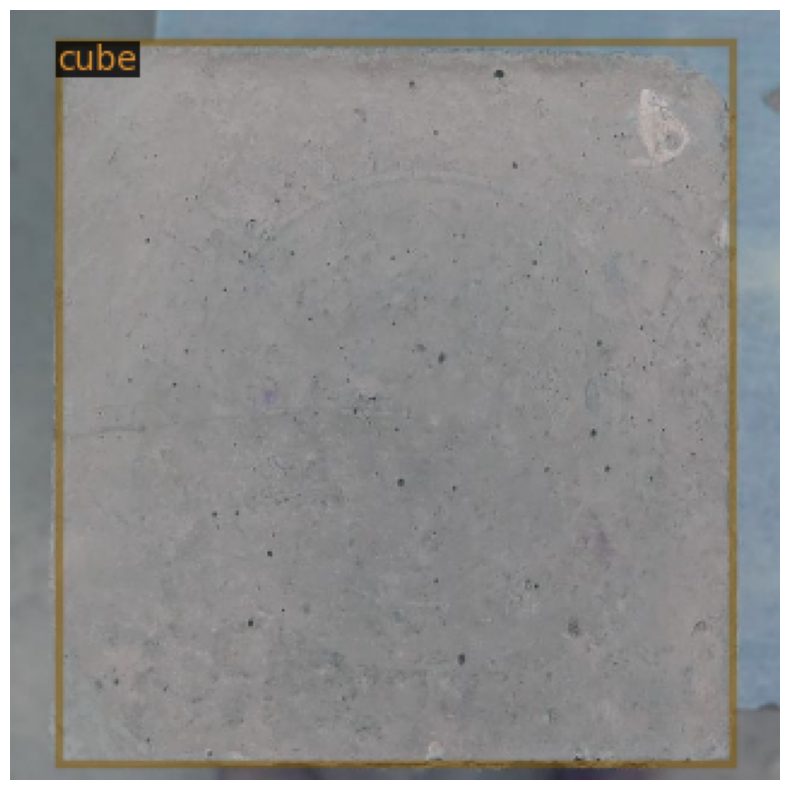

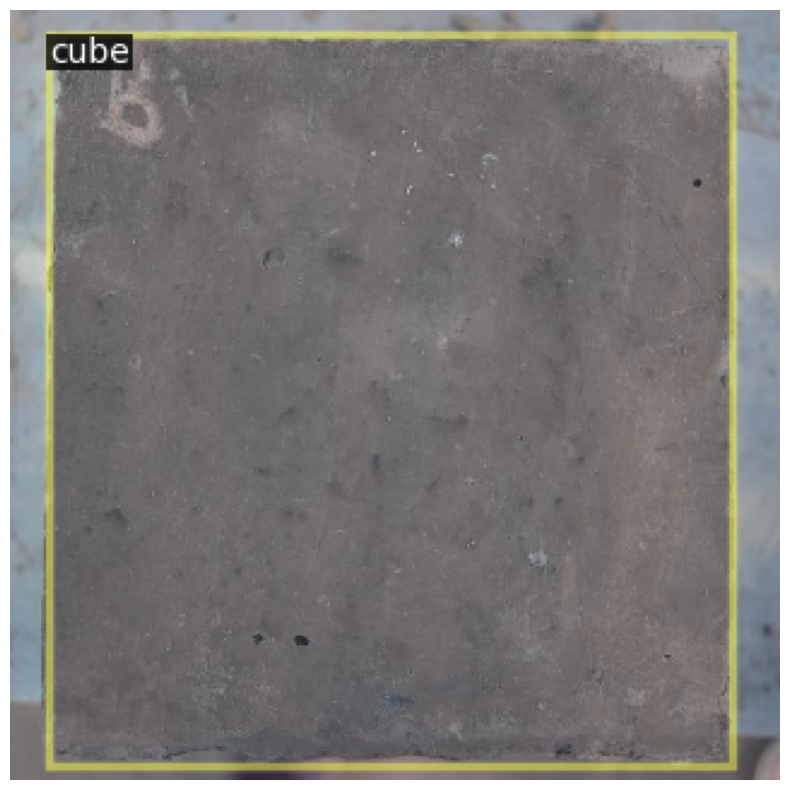

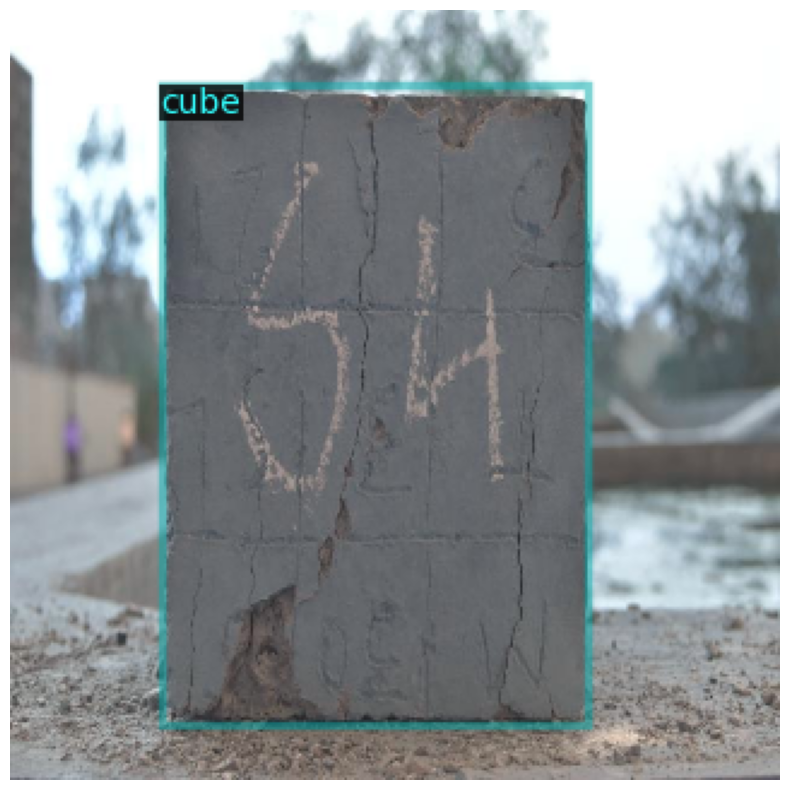

In [9]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode

# Load the validation dataset
dataset_dicts = DatasetCatalog.get("cube_val")

# Loop through 3 random samples
for d in random.sample(dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    
    # Visualize using Detectron2's Visualizer
    visualizer = Visualizer(img[:, :, ::-1], metadata=cube_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    
    # Ensure we get predictions (with bounding boxes and scores)
    if "annotations" in d:
        annotations = d["annotations"]
        for ann in annotations:
            # Add confidence score to the label if 'score' exists
            if "score" in ann:
                bbox = ann["bbox"]
                score = ann["score"]
                # Draw bounding box, label (including confidence score)
                vis = visualizer.draw_box(bbox, label=f"cube: {score:.2f}")
            else:
                vis = visualizer.draw_dataset_dict(d)  # Fallback if no scores

    # Convert image to RGB (from BGR) for matplotlib
    vis_img_rgb = vis.get_image()[:, :, ::-1]
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img_rgb)
    plt.axis('off')
    plt.show()
